In [6]:
import networkx as nx
import graph_utils as gu
import settings
import random
import numpy as np
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kneed import KneeLocator
import seaborn as sns
import pickle
from typing import Dict, List

In [7]:
def debug(msg: str = "") -> None:
    """
    Small method for controlling number of debug messages.
    """
    if settings.DEBUG:
        print(msg)


Load data from python binaries. Processed by the preprocessing notebook.

In [8]:
G = pickle.load(open('resources/create_graph/full_graph.pickle', 'rb'))
edge_map = pickle.load(open('resources/create_graph/edge_map.pickle', 'rb'))

In [9]:
def get_matrix_for_component_graph(component_graph: nx.Graph) -> List[List[int]]:
    """
    Create a probability matrix for every nodepair by executing a number of random walks
    starting at every available node in the given component graph.

    :param component_graph: The graph to calculate the matrix from
    :return: The len(nodes) x len(nodes) matrix containing every start stop pair
    """
    path_len: int = gu.find_longest_path_approx(component_graph=component_graph)

    # Sort component_grpah nodes for a consistent matrix representation (index=node)
    nodes = sorted(component_graph.nodes)
    debug("\n  ".join(["Sorted Node Index:"] + nodes))

    # Run random_walk starting from every node once and save the last visited node
    start_stop_map: Dict[str, str] = {node: [gu.random_walk_in_component(component_graph=component_graph, 
                                                                         start_node=node, 
                                                                         walk_length=path_len) for _ in range(settings.RANDOM_WALK_COUNT)] 
                                      for node in nodes}

    # Initialize matrix full of 0   
    matrix: List[List[int]] = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]

    # Add 1 to every start stop pair and devide by node_count * walk_count
    for start, end_nodes in start_stop_map.items():
        for end in end_nodes:
            matrix[nodes.index(start)][nodes.index(end)] = matrix[nodes.index(start)][nodes.index(end)] + (1 / (settings.RANDOM_WALK_COUNT))

    debug()
    debug('\n  '.join(["EndNode Percentages:"] + [", ".join([f"{value:0.4f}" for value in row]) for row in matrix]))
    debug()
    debug(f"Sum of percentages: {sum([sum(row) for row in matrix])}")
    debug(f"Sum per row: {[sum(row) for row in matrix]}\nrows: {len(matrix)}\n1/rows: {1/len(matrix)}")

    return matrix, nodes


Calculate the probability matrix for every component and marge the results into one big sparse matrix.<br>
The sparse matrix is then smoothed by a given factor.

In [10]:
total_nodes = len(G.nodes()) + 1
matrix = np.zeros((total_nodes, total_nodes))
components = list(nx.connected_components(G))
node_to_index = {}
# Get matrix for every component in G
for i, component in enumerate(components):
    graph = G.subgraph(component)

    # Exclude big graph for dev reason
    m, nodes = get_matrix_for_component_graph(component_graph=graph)
    
    # Loop over row of component matrix
    for i, row in enumerate(m):

        # Add node to node_idx map
        node_to_index[nodes[i]] = len(node_to_index)
        for j, value in enumerate(row):
            matrix[len(node_to_index)][len(node_to_index) + j] = value



# Smoothing factor 10% for the 0 transitions inbetween the component graphs
smoothing_factor = 0.1

for i in range(matrix.shape[0]):
    z = max(1, np.count_nonzero(matrix[i]==0))
    for j in range(matrix.shape[1]):
        if matrix[i][j] == 0:
            matrix[i][j] = smoothing_factor / z
        else:
            matrix[i][j] *= (1 - smoothing_factor)

# Should be ~"number of rows/cols" (here: 5315)
# The result may differ slightly due to rounding errors.
print(np.sum(matrix), matrix.shape[0])


5315.100000000066 5316


Number of components (distinct sets of connected nodes)

In [11]:
len(components)

1379

In [12]:
matrix

array([[1.88111362e-05, 1.88111362e-05, 1.88111362e-05, ...,
        1.88111362e-05, 1.88111362e-05, 1.88111362e-05],
       [1.88359390e-05, 1.88359390e-05, 1.88359390e-05, ...,
        1.88359390e-05, 1.88359390e-05, 1.88359390e-05],
       [1.88465888e-05, 1.88465888e-05, 1.88465888e-05, ...,
        1.88465888e-05, 1.88465888e-05, 1.88465888e-05],
       ...,
       [1.88182160e-05, 1.88182160e-05, 1.88182160e-05, ...,
        4.50000000e-01, 4.50000000e-01, 1.88182160e-05],
       [1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 9.00000000e-01, 1.88146754e-05],
       [1.88146754e-05, 1.88146754e-05, 1.88146754e-05, ...,
        1.88146754e-05, 1.88146754e-05, 9.00000000e-01]])

https://stats.stackexchange.com/questions/134504/using-an-asymmetric-distance-matrix-for-clustering

To run MDS the similarity matrix has to be symmetric. To achieve that we set each pair of nodes
(a, b) ~ (b, a) to its corresponding average $value = \frac{(value_{ab} + value_{ba})}{2}$


In [13]:
def avg(a:float, b: float) -> float:
    """
    Calculcates the average of two values.
    """
    return (a + b)/2


aggs = [min, max, avg]
agg = aggs[2]


for i in range(matrix.shape[0]):
    for j in range(i):
        matrix[i][j] = matrix[j][i] = agg(matrix[i][j], matrix[j][i])

In [14]:
matrix

array([[1.88111362e-05, 1.88235376e-05, 1.88288625e-05, ...,
        1.88146761e-05, 1.88129058e-05, 1.88129058e-05],
       [1.88235376e-05, 1.88359390e-05, 1.88412639e-05, ...,
        1.88270775e-05, 1.88253072e-05, 1.88253072e-05],
       [1.88288625e-05, 1.88412639e-05, 1.88465888e-05, ...,
        1.88324024e-05, 1.88306321e-05, 1.88306321e-05],
       ...,
       [1.88146761e-05, 1.88270775e-05, 1.88324024e-05, ...,
        4.50000000e-01, 2.25009407e-01, 1.88164457e-05],
       [1.88129058e-05, 1.88253072e-05, 1.88306321e-05, ...,
        2.25009407e-01, 9.00000000e-01, 1.88146754e-05],
       [1.88129058e-05, 1.88253072e-05, 1.88306321e-05, ...,
        1.88164457e-05, 1.88146754e-05, 9.00000000e-01]])

In [15]:
dist_matrix = 1 - matrix

In [16]:
dist_matrix

array([[0.99998119, 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998118, 0.99998116, 0.99998116, ..., 0.99998117, 0.99998117,
        0.99998117],
       [0.99998117, 0.99998116, 0.99998115, ..., 0.99998117, 0.99998117,
        0.99998117],
       ...,
       [0.99998119, 0.99998117, 0.99998117, ..., 0.55      , 0.77499059,
        0.99998118],
       [0.99998119, 0.99998117, 0.99998117, ..., 0.77499059, 0.1       ,
        0.99998119],
       [0.99998119, 0.99998117, 0.99998117, ..., 0.99998118, 0.99998119,
        0.1       ]])

https://stackoverflow.com/questions/54055761/checking-triangle-inequality-in-a-massive-numpy-matrix

In [ ]:
def check_triangle_inequality(matrix: np.ndarray, num_checks: int = 1_000_000) -> bool:
    """
    Randomly samples triplets (i, j, k) from distance matrix
    and checks if matrix[i, j] <= matrix[i, k] + matrix[k, j] for all sampled triplets.
    
    :param matrix: The matrix to be checked for triangle inequality.
    :param num_checks: Number of triplets to check.

    :return: True if all sampled triplets satisfy the inequality, else False.
    """
    violations = 0

    for _ in range(num_checks):
        i, j, k = random.sample(range(matrix.shape[0]), 3)
        dij = matrix[i, j]
        dik = matrix[i, k]
        dkj = matrix[k, j]

        if dij > dik + dkj + 1e-8:
            violations += 1

    print(f"\nTotal Violations: {violations} out of {num_checks} checks")

    return violations == 0


result = check_triangle_inequality(dist_matrix, num_checks=10_000_000)



Total Violations: 0 out of 10000000 checks


In [18]:
np.fill_diagonal(dist_matrix, 0)

In [19]:
dist_matrix

array([[0.        , 0.99998118, 0.99998117, ..., 0.99998119, 0.99998119,
        0.99998119],
       [0.99998118, 0.        , 0.99998116, ..., 0.99998117, 0.99998117,
        0.99998117],
       [0.99998117, 0.99998116, 0.        , ..., 0.99998117, 0.99998117,
        0.99998117],
       ...,
       [0.99998119, 0.99998117, 0.99998117, ..., 0.        , 0.77499059,
        0.99998118],
       [0.99998119, 0.99998117, 0.99998117, ..., 0.77499059, 0.        ,
        0.99998119],
       [0.99998119, 0.99998117, 0.99998117, ..., 0.99998118, 0.99998119,
        0.        ]])

In [20]:
max_dim = 16
dims = range(1, max_dim + 1)
stress_vals = []

for d in tqdm(dims, desc="Running MDS", unit="dimension"):
    mds = MDS(n_components=d, dissimilarity='precomputed', random_state=42)
    mds.fit(dist_matrix)
    stress_vals.append(mds.stress_)
    print(f"Dimension {d} → Stress: {mds.stress_:.2f}")


Running MDS:   6%|▋         | 1/16 [00:11<02:48, 11.20s/dimension]

Dimension 1 → Stress: 4706091.38


Running MDS:  12%|█▎        | 2/16 [01:02<08:10, 35.02s/dimension]

Dimension 2 → Stress: 2505327.14


Running MDS:  19%|█▉        | 3/16 [09:12<52:34, 242.64s/dimension]

Dimension 3 → Stress: 1567064.28


Running MDS:  25%|██▌       | 4/16 [11:41<41:06, 205.55s/dimension]

Dimension 4 → Stress: 1096093.85


Running MDS:  31%|███▏      | 5/16 [15:21<38:39, 210.87s/dimension]

Dimension 5 → Stress: 839775.78


Running MDS:  38%|███▊      | 6/16 [20:26<40:29, 242.98s/dimension]

Dimension 6 → Stress: 679627.04


Running MDS:  44%|████▍     | 7/16 [27:04<44:01, 293.54s/dimension]

Dimension 7 → Stress: 570398.08


Running MDS:  50%|█████     | 8/16 [35:22<47:47, 358.47s/dimension]

Dimension 8 → Stress: 491257.31


Running MDS:  56%|█████▋    | 9/16 [44:38<49:02, 420.35s/dimension]

Dimension 9 → Stress: 431367.95


Running MDS:  62%|██████▎   | 10/16 [53:54<46:12, 462.10s/dimension]

Dimension 10 → Stress: 384527.90


Running MDS:  69%|██████▉   | 11/16 [1:00:36<36:59, 443.98s/dimension]

Dimension 11 → Stress: 346987.77


Running MDS:  75%|███████▌  | 12/16 [1:04:56<25:51, 387.80s/dimension]

Dimension 12 → Stress: 316066.16


Running MDS:  81%|████████▏ | 13/16 [1:08:28<16:43, 334.52s/dimension]

Dimension 13 → Stress: 290073.03


Running MDS:  88%|████████▊ | 14/16 [1:11:34<09:39, 289.87s/dimension]

Dimension 14 → Stress: 268014.64


Running MDS:  94%|█████████▍| 15/16 [1:14:20<04:12, 252.52s/dimension]

Dimension 15 → Stress: 249047.53


Running MDS: 100%|██████████| 16/16 [1:16:53<00:00, 288.35s/dimension]

Dimension 16 → Stress: 232579.87


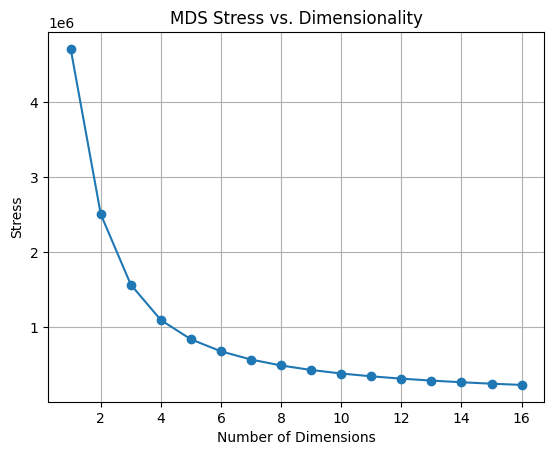

In [21]:
plt.plot(dims, stress_vals, marker='o')
plt.xlabel("Number of Dimensions")
plt.ylabel("Stress")
plt.title("MDS Stress vs. Dimensionality")
plt.grid(True)
plt.show()

In [24]:
stress = np.array(stress_vals)

delta_1 = np.diff(stress)
delta_2 = np.diff(delta_1)


if np.all(delta_2 >= 0):
    print("The stress curve is strictly convex.")
elif np.all(delta_2[:-1] >= -1e-6):
    print("The curve is mostly convex (with minor noise).")
else:
    print("The curve is not convex.")


The stress curve is strictly convex.


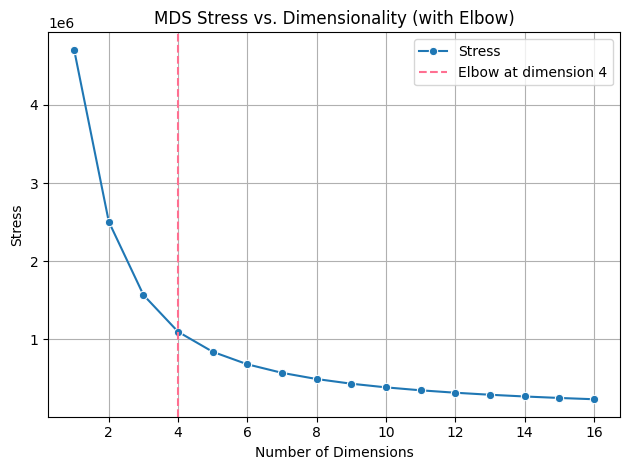

In [26]:
dims = list(range(1, len(stress_vals) + 1))

knee = KneeLocator(dims, stress_vals, curve="convex", direction="decreasing")

sns.lineplot(x=dims, y=stress_vals, marker='o', label="Stress")

plt.axvline(x=knee.knee, color='#FF6F91', linestyle='--', label=f"Elbow at dimension {knee.knee}")
plt.title("MDS Stress vs. Dimensionality (with Elbow)")
plt.xlabel("Number of Dimensions")
plt.ylabel("Stress")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

Using four dimensions seems to capture the structure of colexification relationships. <br> 
Although the stress curve doesn’t have a clear “elbow” point, there’s a noticeable change in slope around four dimensions.<br>
This suggests that adding more dimensions after that gives only small improvements, so four is a good balance between simplicity and accuracy.